In [1]:
# ============================================================================================
# PROJET : AIRBUS - reconnaissance d image avec eolienne vs image sans eolienne
# PROBLEME : probleme classification binaire supervisee dans le domaime de la COMPUTER VISION
# AUTEUR : MS Valdom > LE PICAUT DIDIER
# ============================================================================================

In [2]:
# ATTENTION : bouzou_128512_25632_m_std.csv || *** RMSE = 0.9727

In [3]:
# ============================================================================================
# 1. STACK TECHNIQUE
# ============================================================================================

# utils
import sys # Paramètres et fonctions propres à des systèmes
import os # Les fonctions fournies par os vous permettent de vous connecter a OS linux
import shutil # pour les operations de fichiers
import time # utiliser compteur
import pickle # sauver un objet python en txt
import numpy as np # gestion des tableaux

# Manipulation de données 
import pandas as pd # data en dataframe
from PIL import Image # module de traitement image

# Deep Learning Librairies
import tensorflow as tf # utiliser lib TF

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

# from keras_sequential_ascii import sequential_model_to_ascii_printout
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Visualisation des données
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
ts = time.time()

In [5]:
# ============================================================================================
# 1.1. VERIFICATION STACK TECHNIQUE - MODE CPU
# ============================================================================================
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18211512132527580913
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11054553745796044343
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5307617397355384870
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7540211712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2858159551865116058
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [6]:
# ============================================================================================
# 1.2. VERIFICATION STACK TECHNIQUE - MODE GPU
# ============================================================================================
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

GPU


In [7]:
# ============================================================================================
# 2. PREPROCESSING DES DATAS
# ============================================================================================

In [8]:
# ============================================================================================
# 2.1 CHEMIN DES DATAS
# ============================================================================================

sp = sys.platform

print("Système détecté = ", sp)

sp = 'INSA'


if ('INSA' == sp):
    print("Système INSA")
    
    # données PC INSA
    data_dir = "/home/dlp/insa31/data_airbus_defi/data_airbus_defi/"
    
    # données de tests
    data_dir_test = data_dir+"test/"

    # données d'apprentissage
    ##data_train = data_dir+'train2/'
    data_train = data_dir+'train/'
    data_train_other = data_train+'other/'
    data_train_target = data_train+'target/'

    # creation d'un répertoire de validation à partir des données de test
    ##data_validation = data_dir+'validation2/'
    data_validation = data_dir+'validation/'
    data_validation_other = data_validation+'other/'
    data_validation_target = data_validation+'target/'



Système détecté =  linux
Système INSA


In [9]:
# ============================================================================================
# 2.1.1. type de donnees
# ============================================================================================

In [10]:
#=== DIMENSIONS DES IMAGES (128 X 128 X 3)
img_width_eol = 128
img_height_eol = 128

In [11]:
# ============================================================================================
# 2.1.1. Données d'apprentissage
# ============================================================================================

# data augmentation

print ("Repertoire DataGenerator Train  = ", data_train)

# Pour les valeurs choisies pour la génération des images voir : https://keras.io/preprocessing/image/
train_datagen_eol = kpi.ImageDataGenerator(
        rescale     = 1./255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range = 0.3, #0.2
        zoom_range  = 0.3, #0.2
        horizontal_flip = True)

train_generator_eol = train_datagen_eol.flow_from_directory(
        data_train,
        target_size=(img_width_eol, img_height_eol),
        batch_size=128, #32
        class_mode='binary')


Repertoire DataGenerator Train  =  /home/dlp/insa31/data_airbus_defi/data_airbus_defi/train/
Found 54573 images belonging to 2 classes.


In [12]:
# sanity check
N_train_eol = train_generator_eol.n
print("Taille des échantillons de train : ", N_train_eol)

Taille des échantillons de train :  54573


In [13]:
# ============================================================================================
# 2.1.2. Données de validation
# ============================================================================================

print ("Repertoire DataGenerator Valid = ", data_validation)

# Pour les valeurs choisies pour la génération des images voir : https://keras.io/preprocessing/image/
valid_datagen_eol = kpi.ImageDataGenerator(
        rescale = 1./255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range = 0.3, #0.2
        zoom_range  = 0.3, #0.2
        horizontal_flip = True)
    
validation_generator_eol = valid_datagen_eol.flow_from_directory(
        data_validation,
        target_size=(img_width_eol, img_height_eol),
        batch_size=128, #32
        class_mode='binary')

Repertoire DataGenerator Valid =  /home/dlp/insa31/data_airbus_defi/data_airbus_defi/validation/
Found 13645 images belonging to 2 classes.


In [14]:
# sanity check
N_val_eol = validation_generator_eol.n
print("Taille des échantillons de validation : ", N_val_eol)

Taille des échantillons de validation :  13645


In [15]:
# ============================================================================================
# 3. ARCHITECTURE DU RESEAU DE NEURONES CONVOLUTIONNELLES
# ============================================================================================

model_conv_eol = km.Sequential()

# Source : https://keras.io/layers/convolutional/
 
# bloc1=Conv2D
model_conv_eol.add(kl.Conv2D(128, (3, 3), 
                             input_shape=(img_width_eol, img_height_eol, 3), 
                             data_format="channels_last"))
##model_conv_eol.add(BatchNormalization())
model_conv_eol.add(kl.Activation('relu'))
model_conv_eol.add(kl.MaxPooling2D(pool_size=(2, 2)))

# bloc2=Conv2D
model_conv_eol.add(kl.Conv2D(128, (3, 3)))
model_conv_eol.add(kl.Activation('relu'))
model_conv_eol.add(kl.MaxPooling2D(pool_size=(2, 2)))

# bloc4=Conv2D
model_conv_eol.add(kl.Conv2D(256, (3, 3)))
model_conv_eol.add(kl.Activation('relu'))
model_conv_eol.add(kl.MaxPooling2D(pool_size=(2, 2)))
model_conv_eol.add(kl.Flatten()) # Conversion feature 2D en feature 1D


# sortie perceptron 1 couche "full-connected"
model_conv_eol.add(kl.Dense(512))
model_conv_eol.add(kl.Activation('relu'))
model_conv_eol.add(kl.Dropout(0.5))
model_conv_eol.add(kl.Dense(1))
model_conv_eol.add(kl.Activation('sigmoid')) #binary classification

model_conv_eol.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model_conv_eol.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 128)       147584    
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       295168    
__________

In [16]:
# ============================================================================================
# 4. FIXER LES PARAMETRES D APPRENTISSAGE
# ============================================================================================

# nb epoch
epochs_eol = 50 ## RUN significatif = 100 / depart 10

# taille du batch
batch_size_eol = 256 # 32

print("N_train_eol = ", N_train_eol)
print("N_val_eol = ", N_val_eol)

print("epochs_eol = ", epochs_eol)
print("batch_size_eol = ", batch_size_eol)
print("steps_per_epoch = ", N_train_eol // batch_size_eol)
print("validation_steps = ", N_val_eol // batch_size_eol)

N_train_eol =  54573
N_val_eol =  13645
epochs_eol =  50
batch_size_eol =  256
steps_per_epoch =  213
validation_steps =  53


In [17]:
# ============================================================================================
# 4.1. Sauvegarde du modèle 
# ============================================================================================

#file = "./results/Model4Layers/Model-V1-E{0}-B{1}.h5".format(epochs_eol, batch_size_eol)
file = "/home/dlp/insa31/data_airbus_defi/data_airbus_defi/results/Model4Layers/Model-V1-E{0}-B{1}.h5".format(epochs_eol, batch_size_eol)
print("Sauvegarde du modèle : ", file)
model_conv_eol.save(file)


Sauvegarde du modèle :  /home/dlp/insa31/data_airbus_defi/data_airbus_defi/results/Model4Layers/Model-V1-E50-B256.h5


In [18]:
# ============================================================================================
# 4.2. execution - modele en apprentissage
# ============================================================================================

    
hist = model_conv_eol.fit_generator(
                            train_generator_eol, 
                            steps_per_epoch = N_train_eol // batch_size_eol,     
                            epochs = epochs_eol,
                            validation_data = validation_generator_eol,
                            validation_steps = N_val_eol // batch_size_eol,
                            shuffle = True,
                            verbose =  1, #1
                            use_multiprocessing = False
                                   )
print(hist.history)
print("Learning Time for %d epochs"%(epochs_eol))

Epoch 1/50


/home/dlp/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/dlp/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras_preprocessing/image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


213/213 [==============================] - 69s 324ms/step - loss: 0.3149 - acc: 0.8658 - val_loss: 0.1899 - val_acc: 0.9275
Epoch 2/50
213/213 [==============================] - 67s 314ms/step - loss: 0.1808 - acc: 0.9309 - val_loss: 0.1633 - val_acc: 0.9406
Epoch 3/50
213/213 [==============================] - 66s 310ms/step - loss: 0.1560 - acc: 0.9429 - val_loss: 0.1351 - val_acc: 0.9516
Epoch 4/50
213/213 [==============================] - 66s 310ms/step - loss: 0.1434 - acc: 0.9472 - val_loss: 0.1420 - val_acc: 0.9465
Epoch 5/50
213/213 [==============================] - 66s 310ms/step - loss: 0.1264 - acc: 0.9534 - val_loss: 0.1278 - val_acc: 0.9528
Epoch 6/50
213/213 [==============================] - 66s 309ms/step - loss: 0.1340 - acc: 0.9505 - val_loss: 0.1580 - val_acc: 0.9425
Epoch 7/50
213/213 [==============================] - 66s 310ms/step - loss: 0.1270 - acc: 0.9535 - val_loss: 0.1266 - val_acc: 0.9531
Epoch 8/50
213/213 [==============================] - 66s 309ms/st

In [19]:
# ============================================================================================
# 4.3. Sauvegarde des poids  
# ============================================================================================

file_w = "/home/dlp/insa31/data_airbus_defi/data_airbus_defi/results/Model4Layers/ModelWeigts-V1-E{0}-B{1}.h5".format(epochs_eol, batch_size_eol)
model_conv_eol.save_weights(file_w)
print("Sauvegarde des poids du modèle : ", file_w)


Sauvegarde des poids du modèle :  /home/dlp/insa31/data_airbus_defi/data_airbus_defi/results/Model4Layers/ModelWeigts-V1-E50-B256.h5


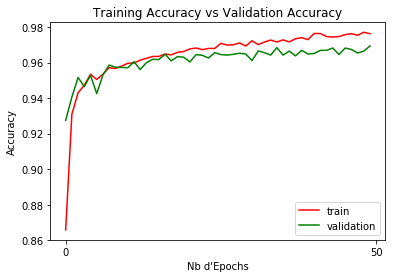

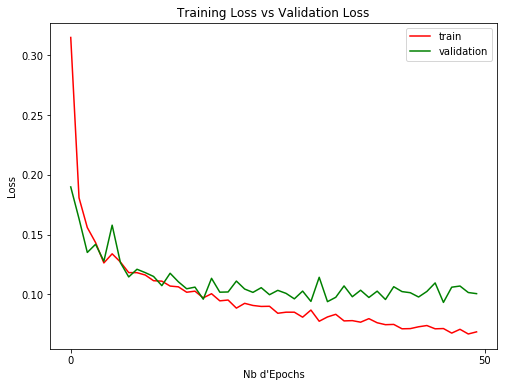

In [20]:
# ============================================================================================
# 4.4. courbes fonctions loss et accuracy
# ============================================================================================

plt.figure(0)
plt.plot(hist.history['acc'],'r', label="train")
plt.plot(hist.history['val_acc'],'g', label="validation")
plt.xticks(np.arange(0, epochs_eol+1, epochs_eol))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Nb d'Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend()

plt.figure(1)
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs_eol+1, epochs_eol))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Nb d'Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


In [21]:
# ============================================================================================
# 4.5. execution - modele en validation
# ============================================================================================


score_conv_val_eol = model_conv_eol.evaluate_generator(validation_generator_eol, N_val_eol / batch_size_eol, verbose=1)
score_conv_train_eol = model_conv_eol.evaluate_generator(train_generator_eol, N_train_eol / batch_size_eol, verbose=1)

# Affichage des résultats
print('Train accuracy:', round(score_conv_train_eol[1],4))
print('Validation accuracy:', round(score_conv_val_eol[1],4))
#print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model_eol)

214/213 [==============================] - 57s 267ms/step
Train accuracy: 0.9802
Validation accuracy: 0.9675


In [22]:
# ============================================================================================
# 4.5. execution - modele en test
# ============================================================================================

In [23]:
print ("Repertoire DataGenerator Test = ", data_dir_test)
test_datagen_eol = kpi.ImageDataGenerator(rescale=1./255)

Repertoire DataGenerator Test =  /home/dlp/insa31/data_airbus_defi/data_airbus_defi/test/


In [24]:
test_generator_eol = test_datagen_eol.flow_from_directory(
    data_dir_test,
    target_size = (img_height_eol, img_width_eol),
    batch_size = 32,             # ATTENTION DOIT ETRE un MULTIPLE du nombre d'images de test !!
    class_mode = None,           # only data, no labels
    shuffle = False)             # keep data in same order as labels

Found 17056 images belonging to 1 classes.


In [25]:
# prediction = production des etiquettes de classes
Y_test_prediction = model_conv_eol.predict_generator(test_generator_eol, steps=533, verbose=1)

533/533 [==============================] - 10s 18ms/step


In [26]:
# affichage des 10 premieres images
os.listdir('/home/dlp/insa31/data_airbus_defi/data_airbus_defi/test/unknown')[:10]

['7499.jpg',
 '13314.jpg',
 '11188.jpg',
 '623.jpg',
 '8486.jpg',
 '15756.jpg',
 '780.jpg',
 '659.jpg',
 '7630.jpg',
 '3311.jpg']

In [27]:
#x = zip_list[0]
#x[0].split('/home/lepic/insa31/data_airbus_defi/data_airbus_defi/data_airbus_defi/test/unknown')

In [28]:
zip_list = list(zip(test_generator_eol.filenames,Y_test_prediction))
zip_list[:10]

[('unknown/0.jpg', array([0.94843376], dtype=float32)),
 ('unknown/1.jpg', array([0.00032817], dtype=float32)),
 ('unknown/10.jpg', array([0.00087431], dtype=float32)),
 ('unknown/100.jpg', array([0.99999905], dtype=float32)),
 ('unknown/1000.jpg', array([1.], dtype=float32)),
 ('unknown/10000.jpg', array([0.9999995], dtype=float32)),
 ('unknown/10001.jpg', array([0.9999994], dtype=float32)),
 ('unknown/10002.jpg', array([0.00013499], dtype=float32)),
 ('unknown/10003.jpg', array([0.01854306], dtype=float32)),
 ('unknown/10004.jpg', array([0.99928856], dtype=float32))]

In [29]:
zip_list = list(zip(test_generator_eol.filenames,Y_test_prediction))

#a = "/home/lepic/insa31/data_airbus_defi/data_airbus_defi/data_airbus_defi/test/unknown/"
a = "unknown/"

##sorted_zip_list = sorted(zip_list, key=lambda x : int(x[0].split("test/")[1].split(".jpg")[0]))

sorted_zip_list = sorted(zip_list, key=lambda x : int(x[0].split(a)[1].split(".jpg")[0]))

sorted_zip_list[:11]
liste_images_test = []
i = 0
for it in sorted_zip_list:
    prediction = it[1][0]
    file = it[0]
    file2 = file.split(a)[1]
   
    if prediction > 0.5:
        liste_images_test.append([file2,1])
    else:
        liste_images_test.append([file2,0])
    i = i + 1
        
print(len(liste_images_test))

df_test = pd.DataFrame(liste_images_test,columns=['name','prediction'])
df_test.head()


file_res = "/home/dlp/insa31/data_airbus_defi/data_airbus_defi/results/Model4Layers/Resultats_liste_images_test-V1-E{0}-B{1}.csv".format(epochs_eol, batch_size_eol)
df_test.to_csv(file_res,index=False,sep=';')
print("Sauvegarde dans : ",file_res)


17056
Sauvegarde dans :  /home/dlp/insa31/data_airbus_defi/data_airbus_defi/results/Model4Layers/Resultats_liste_images_test-V1-E50-B256.csv


In [30]:
te = time.time()
temps = round((te-ts)/60,2)
print (" TEMPS TOTAL EXECUTION =", temps, "mn")

 TEMPS TOTAL EXECUTION = 56.35 mn
